# SG13G2 gm/Id Sizing Script for a 5T OTA w/ Cap. Feedback

**Copyright 2025 Michael Koefinger**

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0



In [1]:
from pygmid import Lookup as lk
import numpy as np
import matplotlib.pyplot as plt
import math as m
# LUTs can be found at https://github.com/iic-jku/analog-circuit-design/tree/main/sizing
table_dir = "../../analog-circuit-design/sizing/"
lv_nmos = lk(table_dir + "sg13_lv_nmos.mat")
lv_pmos = lk(table_dir + "sg13_lv_pmos.mat")
GM_ID_MIN_CONST = 3
GM_ID_MAX_CONST = 32

### Define flavor of active and load devices

In [2]:
mos_active = lv_nmos
mos_load = lv_pmos

### Define System Level Specifications

In [3]:
# Constants
k_t = 1.38e-23
temperature = 300

# Specs
n_bit_stage = 1
n_bit_tot = 3
n_stages = n_bit_tot/n_bit_stage
osr = 1                                         # oversampling ratio
f_b = 50e6                                      # ADC's -3dB-bandwidth
factor_noise_ktc = 0.5                          # kT/C noise budget of overall output noise
nef_ota = 2                                     # noise excess factor of ota noise compared to 4kT*gamma*gm
vo_se = 0.8                                       # single-ended output swing of MDAC

f_s = f_b*2*osr                                 # sampling frequency of the ADC
a_stage = 2**n_bit_stage
beta = 1/a_stage
t_settle = 1/f_s/2
settling_acc = 1/2**(n_bit_tot-n_bit_stage)     # dynamic error at t_settle
settling_acc_db = 20 * np.log10(settling_acc)
n_settle = -np.log(settling_acc)
n_settle_margin = np.ceil(n_settle)
settling_acc_margin = np.exp(-n_settle_margin)
settling_acc_margin_db = 20*np.log10(settling_acc_margin)

tau_o = t_settle / n_settle_margin
bw_cl = 1 / tau_o
gbw = bw_cl / beta
gm_per_cload = 2*n_settle_margin*f_s*a_stage

# Calculate min. required DC gain
# Define static error as
static_error_margin = 1/np.sqrt(2)
dynamic_error_min = 1-settling_acc_margin

gain_dc_min = a_stage*((dynamic_error_min/(settling_acc_margin*static_error_margin))-1)
gain_dc_min_db = 20*np.log10(gain_dc_min)

# Noise Considerations
vo_diff_pp = 2*vo_se
vo_rms = vo_diff_pp/2/np.sqrt(2)
snr_margin_db = np.ceil(-settling_acc_margin_db)
vn_rms_tot = np.sqrt(vo_rms**2/10**(snr_margin_db/10))
vn_rms_ktc = np.sqrt(factor_noise_ktc)*vn_rms_tot
vn_rms_ota = np.sqrt(1-factor_noise_ktc)*vn_rms_tot
c_fb = k_t*temperature*(a_stage+1)/(vn_rms_ktc**2)
c_load = nef_ota*k_t*temperature*(a_stage+1)/(vn_rms_ota**2)
gm = gm_per_cload*c_load

# Print Results
print("n_bits = ", n_bit_tot, " bit")
print("t_settle =", t_settle / 1e-9, " ns")
print("A_stage =", a_stage)
print("beta =", beta)
print("settling_acc =", settling_acc * 100, "%")
print("settling_acc_db =", settling_acc_db," dB")
print("n_settle =", n_settle)
print("settling_acc_margin =", settling_acc_margin * 100, "%")
print("settling_acc_margin_db =", settling_acc_margin_db," dB")
print("n_settle_margin =", n_settle_margin)
print("gm_cload =", gm_per_cload / 1e6, " uS/pF")
print("gbw =", gbw / 2 / np.pi / 1e6, "MHz")
print("bw_cl = ", bw_cl / 2 / np.pi / 1e6, "MHz")
print("dynamic_error_min = ", dynamic_error_min)
print("A0 =", gain_dc_min)
print("A0 =", gain_dc_min_db, " dB")
print("vn_rms_tot = ", vn_rms_tot / 1e-3, "mVrms")
print("vn_rms_ktc = ", vn_rms_ktc / 1e-3, "mVrms")
print("vn_rms_ota = ", vn_rms_ota / 1e-3, "mVrms")
print("c_fb = ", c_fb / 1e-15, "fF")
print("c_load = ", c_load / 1e-15, "fF")
print("gm =", gm / 1e-9, " nS")

n_bits =  3  bit
t_settle = 5.0  ns
A_stage = 2
beta = 0.5
settling_acc = 25.0 %
settling_acc_db = -12.041199826559248  dB
n_settle = 1.3862943611198906
settling_acc_margin = 13.53352832366127 %
settling_acc_margin_db = -17.371779276130074  dB
n_settle_margin = 2.0
gm_cload = 800.0  uS/pF
gbw = 127.32395447351627 MHz
bw_cl =  63.66197723675813 MHz
dynamic_error_min =  0.8646647167633873
A0 = 16.070979571740526
A0 = 24.120846980986762  dB
vn_rms_tot =  71.21557565501779 mVrms
vn_rms_ktc =  50.35701647176669 mVrms
vn_rms_ota =  50.35701647176669 mVrms
c_fb =  0.0048978063865274995 fF
c_load =  0.009795612773054999 fF
gm = 7.836490218443998  nS


### Design 
- Find Trade-off for Cgg/Cgs of Input Transistors! Small Cgs is good for bandwidth and noise, but needs more bias current, due to smaller device and thus smaller gm/Id
- Define cap. ratio which defines ideal CL gain (Acl = 1+G): G = Ci/CFtot
- Define Fanout: FO = CL/Ci (how many stages must one stage drive?)
- Define cap. ratio, between parasitics at the gate Cp and sum of wanted caps: CR = Cp/(Ci+CFtot)
- Rewrite feedback factor beta in terms of ideal gain and cap. ratio: beta = 1/((1+G)(1+CR))

In [4]:
fanout = 2
g = 1
cr = 0.3          # start with ideal cr ratio for loop

#### Circuit Level Specifications

In [5]:
vds_margin = 0.05
vdd = 1.5
vtail = 0.25 + vds_margin
vcmi = vdd/2
vcmo = vdd/2
i_tail_max = 100e-6
i_drain_min = 1e-6
gm_id_active_default = 18
gm_id_load_default = 12
go_active_go_load = 3
c_min = 0.1e-12
l_vec = np.arange(0.2,10,0.2)

#### Inital choices of design parameters

In [6]:
gm_id_active = gm_id_active_default
alpha = 2
gamma_active = 1
gamma_load = 1
beta = 1/((1+g)*(1+cr))

#### Init parasitic caps

In [7]:
c_db_active = 0
c_gd_active = 0
c_dd_load = 0

#### Inital self loading, rerun from here for self loading loop

In [48]:
cp_f = 0#np.abs(c_gd_active)
cp_o = np.abs(c_db_active) + np.abs(c_dd_load)

#### Determine length based on min. dc gain requirement

In [49]:
gm_gds_vec = mos_active.look_up('GM_GDS', GM_ID = gm_id_active, VSB=vtail, VDS=(vcmo-vtail), L=l_vec)
l_active = np.interp(gain_dc_min, gm_gds_vec, l_vec) # 1/2: account for PMOS load by halfing the intrinsic gain
print('L = ',l_active,' um')
l_active_round = max(round(l_active*2)/2, 0.5)
print('L = ',l_active_round,' um')

L =  0.25127752723604674  um
L =  0.5  um


#### Compute caps. based on noise (thermal only)

In [50]:
c_load_tot = (alpha/beta)*k_t*temperature/(vn_rms_ota**2)
c_fb_tot = (c_load_tot-cp_o)/(fanout*g+1-beta)+cp_f
if c_fb_tot < c_min:
    c_fb_tot = c_min
c_input = g*c_fb_tot
c_load = fanout*c_input
cp_i = cr*(c_input+c_fb_tot) # may model this as cgs of input caps
c_load_tot = (1-beta)*c_fb_tot+c_load+cp_o
print("Ci = ", c_input/1e-15, " fF")
print("Cf = ", c_fb_tot/1e-15, " fF")
print("CL = ", c_load/1e-15, " fF")
print("Cgs = ", cp_i/1e-15, " fF")
print("CLtot = ", c_load_tot/1e-15, " fF")

Ci =  100.0  fF
Cf =  100.0  fF
CL =  200.0  fF
Cgs =  59.99999999999999  fF
CLtot =  275.0495966393011  fF


#### Compute gm based on GBW from system spec, requ. total load cap and output parasitcs

In [51]:
gm_active = (c_load_tot)*gbw/beta
#gm_active = (go_active+go_load)/beta*np.sqrt((gbw*(c_load_tot+cp_o)/(go_active+go_load))^2+1)
print("gm = ", gm_active/1e-6, " uS")
print("gm/cgs =", gm_active/cp_i/1e8, "1e8 rad/s")

gm =  572.1031610097464  uS
gm/cgs = 95.35052683495773 1e8 rad/s


#### Size input MOS, based on gm/cgg

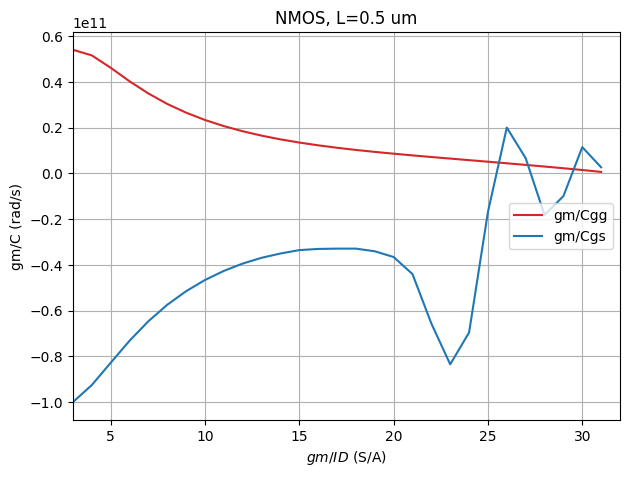

In [52]:
gm_id_vec = np.arange(GM_ID_MIN_CONST,GM_ID_MAX_CONST,1)
gm_cgs_vec = mos_active.look_up('GM_CGS', GM_ID = gm_id_vec, VSB=vtail, VDS=(vcmo-vtail), L=l_active_round)
gm_cgg_vec = mos_active.look_up('GM_CGG', GM_ID = gm_id_vec, VSB=vtail, VDS=(vcmo-vtail), L=l_active_round)
gm_cgb_vec = mos_active.look_up('GM_CGB', GM_ID = gm_id_vec, VSB=vtail, VDS=(vcmo-vtail), L=l_active_round)
fig, ax1 = plt.subplots()
ax1.grid(axis='both')
ax1.set_xlabel('$gm/ID$ (S/A)')
ax1.set_ylabel('gm/C (rad/s)')
ax1.plot(gm_id_vec, gm_cgg_vec, color='tab:red')
ax1.plot(gm_id_vec, gm_cgs_vec, color='tab:blue')
#ax1.plot(gm_id_vec, gm_cgb_vec, color='tab:green')
ax1.tick_params(axis='y')
ax1.legend(loc='center right', labels=['gm/Cgg','gm/Cgs', 'gm/Cgb'])
fig.tight_layout()
plt.title('NMOS, L='+str(l_active_round)+' um')
plt.xlim(3, 32)
plt.show()

In [53]:

gm_id_ = mos_active.look_up('GM_ID', GM_CGG = gm_active/cp_i, VSB=vtail, VDS=(vcmo-vtail), L=l_active_round)
print("gm/id = ", gm_id_)
if type(gm_id_) != list:
    if gm_id_ >= GM_ID_MIN_CONST and gm_id_ <= GM_ID_MAX_CONST:
        gm_id_active = gm_id_
    else:
        gm_id_active = gm_id_active_default
else:
    gm_id_active = gm_id_active_default

print("gm/id = ", gm_id_active)

i_drain = gm_active/gm_id_active
print("id = ", i_drain)

if i_drain < i_drain_min:
    i_drain = i_drain_min
    gm_active = gm_id_active*i_drain

if i_drain > i_tail_max/2:
    i_drain = i_tail_max/2

j_drain = mos_active.look_up('ID_W', GM_ID=gm_id_active, VSB=vtail, VDS=(vcmo-vtail), L=l_active_round)
w_active = i_drain/j_drain
w_active_round = max(round(w_active*2)/2, 0.5)
vdsat_active = 2/gm_id_active
print("IDS = ", i_drain/1e-6, " uA")
print("W = ", w_active_round, " um")

gm/id =  18.8761683889709
gm/id =  18.8761683889709
id =  3.030822512390909e-05
IDS =  30.30822512390909  uA
W =  18.5  um


#### Find best gm/id for the load

SNR_max =  68.31435513701012  dB @ gm/id =  9.438084194485448 S/A


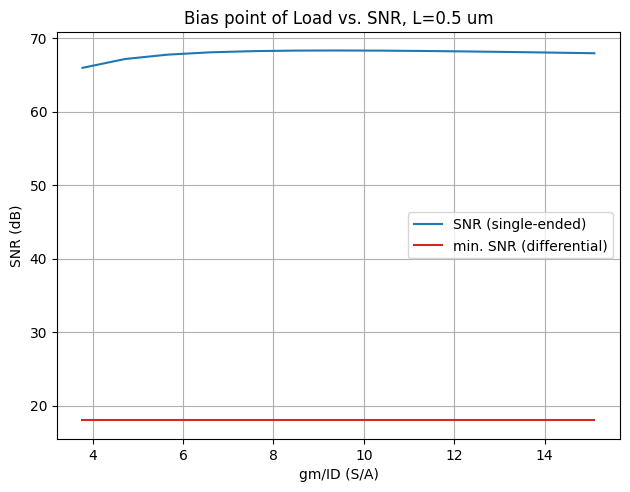

In [54]:
STH_active = mos_active.look_up('STH_GM', GM_ID = gm_id_active, VSB=vtail, VDS=(vcmo-vtail), L=l_active_round)*gm_active
gamma_active = STH_active/(4*k_t*temperature*gm_active)
gm_load_vec = np.arange(0.2,0.8,0.05)*gm_active
alpha_vec = gamma_active*(1+gamma_load/gamma_active*gm_load_vec/gm_active)
gm_id_load_vec = gm_load_vec/i_drain
# TODO: check if calc. snr lines up with simulation, single ended vs. differential issue?
vo_p_se_vec = vdd-vtail-2/gm_id_active-2/gm_id_load_vec
p_sig_vec = (vo_p_se_vec/np.sqrt(2))**2
p_noi_vec = alpha_vec/beta*k_t*temperature/c_load_tot
snr_vec = 10*np.log10(p_sig_vec/p_noi_vec)
snr_max = np.max(snr_vec)
idx = np.squeeze(np.where(np.isclose(snr_vec,snr_max)))
gm_load = gm_load_vec[idx]
print("SNR_max = ", snr_max, " dB @ gm/id = ", gm_load/i_drain, "S/A")

fig, ax1 = plt.subplots()
ax1.grid(axis='both')
ax1.set_xlabel('gm/ID (S/A)')
ax1.set_ylabel('SNR (dB)')
ax1.plot(gm_id_load_vec, snr_vec, color='tab:blue')
ax1.plot(gm_id_load_vec, snr_margin_db*np.ones(len(snr_vec)), color='tab:red')
ax1.tick_params(axis='y')
ax1.legend(loc='center right', labels=['SNR (single-ended)', 'min. SNR (differential)'])
fig.tight_layout()
plt.title('Bias point of Load vs. SNR, L='+str(l_active_round)+' um')
plt.show()

#### Size Load Device based on optimum dyn. range

In [45]:
gm_id_load_idx_offset = 0
print("Vo_se_p = ",vo_p_se_vec[idx+gm_id_load_idx_offset], " Vp")
gm_load = gm_load_vec[idx+gm_id_load_idx_offset]
gm_id_load = gm_load/i_drain
print("SNR_max = ", snr_vec[idx+gm_id_load_idx_offset], " dB @ gm/id = ", gm_id_load, "S/A")
vdsat_load = 2/gm_load/i_drain

go_active = gm_active/mos_active.look_up('GM_GDS', GM_ID = gm_id_active, VSB=vtail, VDS=(vcmo-vtail), L=l_active_round)
go_load_desired = go_active/go_active_go_load
gm_gds_load_vec = mos_load.look_up('GM_GDS', GM_ID = gm_id_load, VSB=0, VDS=vcmo, L=l_vec)
l_load = np.interp(go_load_desired, gm_gds_load_vec, l_vec)                                                      # account for PMOS load by halfing the intrinsic gain
print('L = ',l_load,' um')
l_load_round = max(round(l_load*2)/2, 0.5)
print('L = ',l_load_round,' um')

j_load = mos_load.look_up('ID_W', GM_ID = gm_id_load, VSB=0, VDS=vcmo, L=l_load_round)
w_load = i_drain/j_load
print('W = ',w_load,' um')
w_load_round = max(round(w_load*2)/2, 0.5)
print('W = ',w_load_round,' um')

Vo_se_p =  0.8821390111465609  Vp
SNR_max =  68.31443207615904  dB @ gm/id =  9.43808804855652 S/A
L =  0.2  um
L =  0.5  um
W =  10.045166148957952  um
W =  10.0  um


#### Find correct $\alpha$ for opt. DR

In [46]:
STH_load = mos_load.look_up('STH_GM', GM_ID = gm_id_load, VSB = 0, VDS = vcmo, L=l_load_round)*gm_load
gamma_load = STH_load/(4*k_t*temperature*gm_load)
alpha = gamma_active*(1+(gamma_load*gm_load)/(gamma_active/gm_active))
print(alpha)

0.743849282951927


#### Account for self loading

In [47]:
cdd_w_active = mos_active.look_up('CDD_W', GM_ID = gm_id_active, VSB=vtail, VDS=(vcmo-vtail), L=l_active_round)
cgd_w_active = mos_active.look_up('CGD_W', GM_ID = gm_id_active, VSB=vtail, VDS=(vcmo-vtail), L=l_active_round)
cdd_w_load = mos_load.look_up('CDD_W', GM_ID = gm_id_load, VSB=0, VDS=vcmo, L=l_load_round)
c_db_active = (cdd_w_active - cgd_w_active)*w_active_round
c_gd_active = cgd_w_active*w_active_round
c_dd_load = cdd_w_load*w_load_round
print(c_db_active)
print(c_gd_active)
print(c_dd_load)

5.939730380932811e-15
1.1031567508976287e-14
7.571404719906795e-15
